# A Sketch using the new sambuca-core functionality

This is a sketch of one way to perform Sambuca parameter estimation using the sambuca-core functionality.

I prepared this notebook for two reasons: first, as a design sketch for functionality that I plan to implement in the actual sambuca package, and second as reference notes for other users of the system.

# Set up the environment
Nothing fancy here, just some imports and other setup code.

First, import the standard Scipy stuff, and configure matplotlib

In [12]:
%matplotlib inline
from collections import namedtuple
from pkg_resources import resource_filename
from os.path import join

import numpy as np
import matplotlib.pyplot as plt
import rasterio
from scipy.io import loadmat
from scipy.optimize import minimize

#import spectral as sp
#import spectral.io.envi as envi

# set some controls on numpy formatting
# 5 decimal places, suppress scientific notation
np.set_printoptions(precision=5, suppress=True)

# set the matplotlib style to emulate ggplot2 from R
plt.style.use('ggplot')
plot_width = 12
plot_height = plot_width * 3/4

Now import the sambuca and sambuca-core packages:

In [13]:
import sambuca as sb
import sambuca_core as sbc

# Utility Functions

In [14]:
plot_items = []

In [15]:
def print_parameters(p):
    print(
'''\
    CHL:  {0:10.5f}
    CDOM: {1:10.5f}
    TR:   {2:10.5f}
    H:    {3:10.5f}
    Q:    {4:10.5f}'''
          .format(p.chl,p.cdom,p.nap,p.depth,p.substrate_fraction))

In [16]:
def show_plot():
    plt.figure(figsize=(plot_width, plot_height))
    for label, data in plot_items:
        plt.plot(data[0], data[1], label=label)
        
    plt.legend(loc='upper right')
    plt.show()

In [17]:
def add_sensor_filter_to_plot(filter_data):
    band_centre_wavelengths = filter_data[0]
    sensor_filter = filter_data[1]
    num_bands = sensor_filter.shape[0]

    for band in range(num_bands):
        band_data = sensor_filter[band, :]
        plot_items.append((
                'Filter Band {0}'.format(band),
                (band_centre_wavelengths, band_data)))

# Load the reference data

## Configuration

In [18]:
base_path = '/home/dc/code/sambuca-project/bioopti_data/'

observed_rrs_base_path = '../wl_alos_data/inputs'
observed_rrs_raster_path = join(observed_rrs_base_path, 'WL_ALOS_R_0_sub120.img')

sensor_filter_path = join(base_path, 'sensor_filters')
sensor_filter_name = 'ALOS'

substrate_path = join(base_path, 'Substrates')
substrate1_name = 'moreton_bay_speclib:white Sand'
substrate2_name = 'moreton_bay_speclib:brown Mud'

aphy_star_path = join(base_path, 'SIOP/WL08_aphy_1nm.hdr')
aphy_star_name = 'wl08_aphy_1nm:WL08_aphy_star_mean_correct.csv:C2'

awater_path = join(base_path, 'SIOP/aw_350_900_lw2002_1nm.csv')
awater_name = 'aw_350_900_lw2002_1nm:0.0204'

## Parameters

Define the upper and lower bounds for the free parameters.

In [19]:
p_min = sb.FreeParameters(
    chl=0.01, 
    cdom=0.0005, 
    nap=0.2,
    depth=0.1,
    substrate_fraction=0)

In [20]:
p_max = sb.FreeParameters(
    chl=0.22, 
    cdom=0.015, 
    nap=2.4,
    depth=17.4,
    substrate_fraction=1)

Create some initial parameters, one random and one as the mid point of each parameter range:

In [21]:
pmin = np.array(p_min)
pmax = np.array(p_max)
num_params = len(pmin)
p0_rand = np.random.random(num_params) * (pmax - pmin) + pmin
p0_mid = (pmax - pmin) / 2

print('p0_rand: ', p0_rand)
print('p0_mid: ', p0_mid)

p0_rand:  [ 0.08427  0.00708  0.35477  4.0425   0.68916]
p0_mid:  [ 0.105    0.00725  1.1      8.65     0.5    ]


## Observed Reflectance

### Load the ENVI raster with the rasterio library
And use that to store some basic metadata...

In [22]:
observed_rrs_width = 0
observed_rrs_height = 0

with rasterio.drivers():
    with rasterio.open(observed_rrs_raster_path) as src:
        print('Observed rrs file: ', observed_rrs_raster_path)
        print('Width, height: ', src.width, src.height)
        print('crs: ', src.crs)
        print('affine: ', src.affine)
        print('num bands: ', src.count)
        print('band indicies: ', src.indexes)
        
        observed_rrs_width = src.width
        observed_rrs_height = src.height

Observed rrs file:  ../wl_alos_data/inputs/WL_ALOS_R_0_sub120.img
Width, height:  120 120
crs:  {'init': 'epsg:32756'}
affine:  | 10.00, 0.00, 452754.14|
| 0.00,-10.00, 6431592.57|
| 0.00, 0.00, 1.00|
num bands:  4
band indicies:  [1, 2, 3, 4]


## Load SIOPs and other data using the sambuca-core functions

### Load the sensor filter:

In [23]:
sensor_filters = sbc.load_sensor_filters(sensor_filter_path)

# We don't need to do this, but it lets us see the name of all loaded filters
sensor_filters.keys()

dict_keys(['LS8QB', 'LS5', 'LS5b', 'ALOS', 'CASI04', 'LS7b', 'LS7c', 'QB', 'LS8w', 'LS7', 'PHILLS', 'WV27B', 'LS8', 'WV2', 'Hymap06', 'LDCM', 'LS8b'])

In [24]:
sensor_filter = sensor_filters[sensor_filter_name]

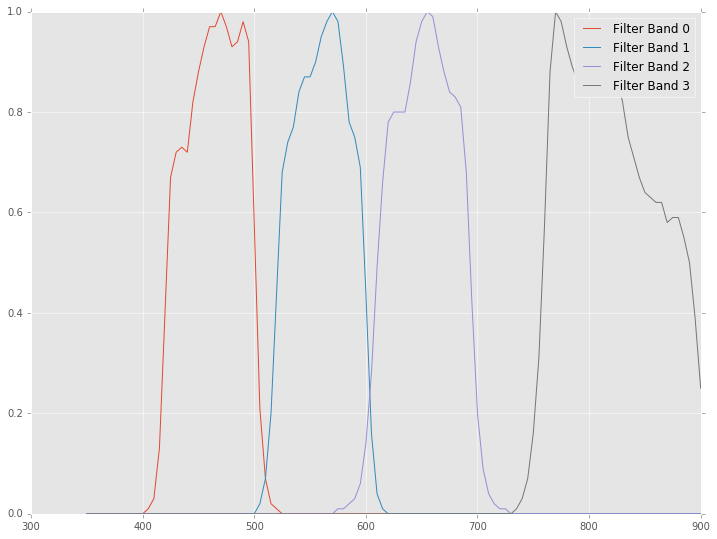

In [25]:
plot_items.clear()
add_sensor_filter_to_plot(sensor_filter)
show_plot()

### Load the substrates
This example uses the load_all_spectral_libraries function to return a dictionary of everything found in a directory. We then retrieve the required substrates from the dictionary.

In [26]:
all_substrates = sbc.load_all_spectral_libraries(substrate_path)
substrate1 = all_substrates[substrate1_name]
substrate2 = all_substrates[substrate2_name]

Note that the sambuca_core spectral library loading functions return a dictionary of (band-centre wavelength, value) tuples. Thus substrate1 and substrate2 are tuples.

### Aphystar
Here we load a single file, although we could have used the load_all_spectral_libraries approach with the same result.

Note that although we specify a single file, a dictionary is still returned. This is for two reasons: consistency with the other functions, and because a single file may contain multiple spectra.

In [27]:
aphy_star = sbc.load_spectral_library(aphy_star_path)[aphy_star_name]

### Awater

In [28]:
awater = sbc.load_spectral_library(awater_path)[awater_name]

### Plot the SIOPS, just because we can :)

Leave awater out of the first plot, because the scale obscures other values

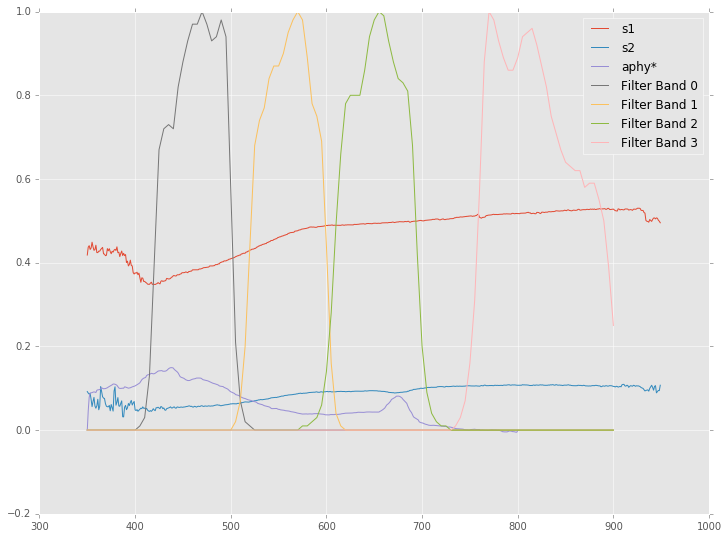

In [29]:
plot_items.clear()
plot_items.append(('s1', substrate1))
plot_items.append(('s2', substrate2))
plot_items.append(('aphy*', aphy_star))
add_sensor_filter_to_plot(sensor_filter)
show_plot()

Second plot, with awater

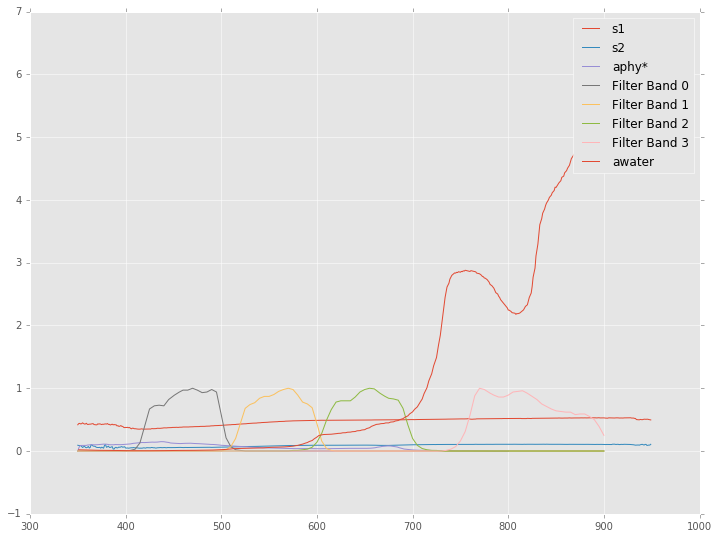

In [30]:
plot_items.append(('awater', awater))
show_plot()

# Spatial run with single substrate pair

**The outline of the algorithm here is**:
- Load the input data
- Load the observed rrs raster with rasterio
- Set the parameter bounds and initial values
- Create the objective object
- Create a pixel result handler that does something with the pixel results from the parameter estimator
- run the parameter estimator on the pixel range

## A note on parallelism

This notebook is deliberately using serial code. It is intended as a documented version of my working notes on Sambuca, for use by future authors in completing the system.

I think that a course-grained parallelism approach will work well for Sambuca, with the decomposition based on spatial tiling of the total problem area. A suggested outline is:
- Spatial decomposition splits the input region into a user defined number of spatial tiles
    - This need not require the generation of new files. It might be sufficient to generate a list of regions (eg: pixel bounds (xmin=100, xmax=200, ymin=3000, ymax=3100)) that will tell each sambuca process the data subset it should operate on.
- A separate serial Sambuca process is executed on each tile
    - depending on the implementation method, the results could then be written out to separate files encoded with the tile index, or they could be passed in memory back to the main process for the composition stage (eg: an MPI-like approach).
- When all Sambuca runs are complete, a spatial composition stage joins the tiled outputs into a final set of spatial outputs.

Python parallel processing approaches that look promising are:
### IPython Parallel
- Master python code does these tasks
    - set up problem (input spectra, parameter bounds, etc)
    - defines (probably from user configuration)
        - required output products
    - initialise the IPython parallel framework (ipcluster, engines etc)
    - spatial decomposition into tiles, with each tile being processed by a single engine
        - each engine will be doing serial processing over its allocated spatial region in much the same way as the code in this notebook.
    - recompose the results from each engine into the final set of outputs
- It remains to be seen if the best performance will be achieved by:
    - having each parallel task generate a full set of results by feeding the estimated parameters back into the Sambuca model, or
    - simply returning the estimated parameters (or a null-result for pixels that fail to converge) to the master code. These parameters could then be used to generate the rest of the outputs.

The first approach reduces the amount of parallelism, but also reduces the amount of data being passed as messages. I suspect the second approach will be preferable.
   
### Rasterio & rio-mucho  
The rio-mucho library promises parallel processing of spatial data by providing a parallel spatial tiling system on top of rasterio.
- This is worth investigation.
- However, the current documentation suggests that rio-mucho only handles writing to a single output raster. If so, this would require all Sambuca outputs being written into one raster. Depending on the required outputs, this could easily generate a raster with dozens of bands, many of which don't really belong together.
    - If this approach gives good performance, then post-processing could be used to split the *uber-raster* into separate files.        

# Define the spatial region

For the sake of simplicity, I am just defining a simple rectangle of pixel coordinates. In the final application this will could be one of:
- An entire raster with the number of tiles specified
- A spatial polygon along with the number of tiles to decompose into

In [31]:
xstart = 60
xend = 100
#xend = xstart + 30
xspan = xend - xstart
ystart = 80
yend = 100
#yend = ystart + 10
num_pixels = xspan * (yend - ystart)

# Do the run

## Create some IPython widgets for progress reporting

In [34]:
from IPython.display import clear_output, display
from ipywidgets import IntProgress, Text

progress_bar = IntProgress()
text_widget = Text()
skip_count_widget = Text()
progress_bar.max = num_pixels
n = 0
skip_count = 0

Note this example skips over some extra spatial details that should be addressed:
- Getting the invalid pixels mask from rasterio, so that we don't try to process pixels with no data


In [ ]:
display(text_widget)
display(skip_count_widget)
display(progress_bar)

# Load the observed rrs
observed_rrs = None

with rasterio.drivers():
    with rasterio.open(observed_rrs_raster_path) as obs_rrs_src:
        # load the observed_rrs raster into a numpy array
        # The array will have shape (band, row, col)
        observed_rrs = obs_rrs_src.read()
        
assert observed_rrs is not None
print(observed_rrs.shape)

In [38]:
# Create the objective
objective = sb.SciPyObjective(sensor_filter, fixed_parameters, nedr)

AttributeError: module 'sambuca' has no attribute 'SciPyObjective'

In [37]:
for x in range(xstart, xend):
    for y in range(ystart, yend):
        obs_spectra = observed_rrs[,x,y]
        
        # Quick and dirty check because we are not masking out the no-data pixels
        if not np.allclose(obs_spectra, 0):

            result = minimize(
                        objective, 
                        p0, 
                        method='SLSQP', 
                        bounds=p_bounds, 
                        options={'disp':False, 'maxiter':500})

            # writer/recorder pattern
            pixel_result_handler(x, y, result['x'], obs_spectra)
        else:
            skip_count += 1
            skip_count_widget.value = 'Pixels skipped (bad input spectra): {0}'.format(skip_count)
        
        # update the progress bar
        text_widget.value = 'x: {0}  y: {1}  n: {2}'.format(x, y, n)
        pb.value = n
        n += 1

(4, 120, 120)
